# Get and explore dataset

In [33]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re
import statistics

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [4]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [7]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from tensorflow.keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

In [67]:
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
review_size = []
num_reviews = len(data)
for i in range(num_reviews):
    len_review = len(data[i].split())
    review_size.append(len_review)

mean_review = statistics.mean(review_size)
std_review = statistics.stdev(review_size)

# - Calculate the number of unique words in the dataset
all_wordsss = []
for i in range(num_reviews):
    wordsss = data[i].split()
    all_wordsss.append(wordsss)
all_wordsss = [i for j in all_wordsss for i in j]
uniq_wordsss = list(set(all_wordsss))
print('Total number of words is: ', len(all_wordsss))
print('Total number of UNIQUE words is: ',len(uniq_wordsss))

Total number of words is:  7776
Total number of UNIQUE words is:  2559


In [63]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [90]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length

from keras.preprocessing.sequence import pad_sequences

tokenized_data_padded = pad_sequences(tokenized_data, padding='post', maxlen=4)

tokenized_data_padded


array([[18,  4,  2, 19],
       [ 2,  4,  2,  0],
       [ 0,  0,  0,  0],
       ...,
       [ 0,  0,  0,  0],
       [ 6,  0,  0,  0],
       [ 0,  0,  0,  0]])

In [117]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.

from sklearn.utils import shuffle
#shuffle data and rename 
data_plus = shuffle(tokenized_data_padded, random_state=123)
labels_plus = shuffle(labels, random_state=123)

#test set size and train set size initialized
train_size = int(len(data_plus) * 0.80)
test_size = len(data_plus) - train_size

#splitting data into training set and test set
X_train, X_test = data_plus[0:train_size,:], data_plus[train_size:len(data_plus),:]
y_train, y_test = labels_plus[0:train_size,:], labels_plus[train_size:len(labels_plus),:]


In [185]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):      
    #To do
    y_test = to_class(y_test)
    y_pred = model.predict(X_test)
    y_pred = to_class(y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    av_f1 = f1_score(y_test, y_pred, average='micro')
    conf_mat = confusion_matrix(y_test, y_pred)
    return print('Precision:', prec), print('Recall:', rec), print('f1 score:', av_f1), print('confunsion matrix: \n', conf_mat)
    

# Build and tune model

Define network architecture

In [189]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define model architecture for with embedding layer's output_dim = 10, 25, 50 and 100.
model10 = Sequential()
model10.add(tf.keras.layers.Embedding(input_dim=2559,output_dim=10, input_length=4))    # output_dim=10, 25, 50 0r 100.
model10.add(tf.keras.layers.SpatialDropout1D(0.2))
model10.add(tf.keras.layers.BatchNormalization())
model10.add(LSTM(32))
model10.add(Dense(2, activation='softmax'))

model25 = Sequential()
model25.add(tf.keras.layers.Embedding(input_dim=2559,output_dim=10, input_length=4))    # output_dim=10, 25, 50 0r 100.
model25.add(tf.keras.layers.SpatialDropout1D(0.2))
model25.add(tf.keras.layers.BatchNormalization())
model25.add(LSTM(32))
model25.add(Dense(2, activation='softmax'))

model50 = Sequential()
model50.add(tf.keras.layers.Embedding(input_dim=2559,output_dim=10, input_length=4))    # output_dim=10, 25, 50 0r 100.
model50.add(tf.keras.layers.SpatialDropout1D(0.2))
model50.add(tf.keras.layers.BatchNormalization())
model50.add(LSTM(32))
model50.add(Dense(2, activation='softmax'))

model100 = Sequential()
model100.add(tf.keras.layers.Embedding(input_dim=2559,output_dim=10, input_length=4))    # output_dim=10, 25, 50 0r 100.
model100.add(tf.keras.layers.SpatialDropout1D(0.2))
model100.add(tf.keras.layers.BatchNormalization())
model100.add(LSTM(32))
model100.add(Dense(2, activation='softmax'))

Train model

In [190]:
batch_size = 10
num_epochs = 5
# compiling and training the moddel with embedding layer's output_dim = 10
model10.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model10.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)
print('Training model 10 complete \n')

# compiling and training the moddel with embedding layer's output_dim = 25
model25.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model25.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)
print('Training 25 complete \n')

# compiling and training the moddel with embedding layer's output_dim = 25
model50.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model50.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)
print('Training model 50 complete \n')

# compiling and training the moddel with embedding layer's output_dim = 25
model100.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model100.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs)
print('Training model 100 complete')


Epoch 1/5
144/144 [==============================] - 3s 4ms/step - loss: 0.6881 - accuracy: 0.5593
Epoch 2/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6666 - accuracy: 0.5823
Epoch 3/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6651 - accuracy: 0.5844
Epoch 4/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6560 - accuracy: 0.6116
Epoch 5/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6508 - accuracy: 0.6039
Training model 10 complete 

Epoch 1/5
144/144 [==============================] - 5s 4ms/step - loss: 0.6885 - accuracy: 0.5453
Epoch 2/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6733 - accuracy: 0.5858
Epoch 3/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6618 - accuracy: 0.5983
Epoch 4/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.6095
Epoch 5/5
144/144 [==============================] - 1s 4ms/step - loss: 0.6500 

Examine performance of model

In [191]:
metric_values = model10.evaluate(x=X_train, y=y_train)
print('Model 10 performance')
for metric_value, metric_name in zip(metric_values, model10.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))
print('\n')

metric_values = model25.evaluate(x=X_train, y=y_train)
print('Model 25 performance')
for metric_value, metric_name in zip(metric_values, model25.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))
print('\n')

metric_values = model50.evaluate(x=X_train, y=y_train)
print('Model 50 performance')
for metric_value, metric_name in zip(metric_values, model50.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))
print('\n')

metric_values = model100.evaluate(x=X_train, y=y_train)
print('Model 100 performance')
for metric_value, metric_name in zip(metric_values, model100.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

45/45 [==============================] - 1s 2ms/step - loss: 0.6400 - accuracy: 0.6206
Model 10 performance
loss: 0.6400451064109802
accuracy: 0.6206415891647339


45/45 [==============================] - 1s 2ms/step - loss: 0.6348 - accuracy: 0.6227
Model 25 performance
loss: 0.6347856521606445
accuracy: 0.6227335929870605


45/45 [==============================] - 1s 2ms/step - loss: 0.6389 - accuracy: 0.6304
Model 50 performance
loss: 0.6389313340187073
accuracy: 0.6304044723510742


45/45 [==============================] - 1s 2ms/step - loss: 0.6382 - accuracy: 0.6255
Model 100 performance
loss: 0.6381658911705017
accuracy: 0.625523030757904


In [192]:
assess_model(model10, X_test, y_test)
print('\n')
assess_model(model25, X_test, y_test)
print('\n')
assess_model(model50, X_test, y_test)
print('\n')
assess_model(model100, X_test, y_test)

Precision: 0.6407185628742516
Recall: 0.5879120879120879
f1 score: 0.6239554317548747
confunsion matrix: 
 [[117  60]
 [ 75 107]]


Precision: 0.6233183856502242
Recall: 0.7637362637362637
f1 score: 0.6462395543175488
confunsion matrix: 
 [[ 93  84]
 [ 43 139]]


Precision: 0.6417910447761194
Recall: 0.7087912087912088
f1 score: 0.6518105849582173
confunsion matrix: 
 [[105  72]
 [ 53 129]]


Precision: 0.6398104265402843
Recall: 0.7417582417582418
f1 score: 0.6573816155988857
confunsion matrix: 
 [[101  76]
 [ 47 135]]


(None, None, None, None)

Plot graphs for accuracy and loss

Epoch 1/3
144/144 [==============================] - 1s 6ms/step - loss: 0.5914 - accuracy: 0.6360 - val_loss: 0.6390 - val_accuracy: 0.6574
Epoch 2/3
144/144 [==============================] - 1s 6ms/step - loss: 0.5884 - accuracy: 0.6534 - val_loss: 0.6383 - val_accuracy: 0.6574
Epoch 3/3
144/144 [==============================] - 1s 5ms/step - loss: 0.5844 - accuracy: 0.6562 - val_loss: 0.6351 - val_accuracy: 0.6490


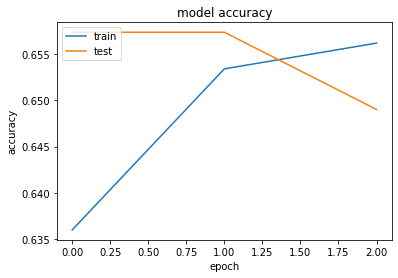

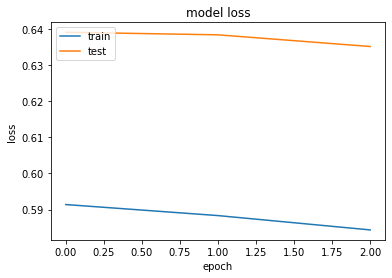

In [198]:
history = model50.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=3,
                      validation_data=(X_test, y_test))
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#while changing number of epochs, we learn that model converges at 3 epochs hence this is the optimal number

# Make a prediction

In [200]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=4)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.

true_y = ["positive","negative", "positive", "negative", "positive"]
print('True reviews : \n', true_y, '\n')

y_pred = model10.predict(padded)
print("model with  embedding layer is set to 10")
print(to_word_label(y_pred))
print("\n")

y_pred = model25.predict(padded)
print("model with  embedding layer is set to 25")
print(to_word_label(y_pred))
print("\n")

y_pred = model50.predict(padded)
print("model with  embedding layer is set to 50")
print(to_word_label(y_pred))
print("\n")

y_pred = model100.predict(padded)
print("model with  embedding layer is set to 100")
print(to_word_label(y_pred))
print("\n")


True reviews : 
 ['positive', 'negative', 'positive', 'negative', 'positive'] 

model with  embedding layer is set to 10
['negative', 'negative', 'positive', 'positive', 'negative']


model with  embedding layer is set to 25
['negative', 'negative', 'positive', 'positive', 'negative']


model with  embedding layer is set to 50
['negative', 'positive', 'positive', 'positive', 'negative']


model with  embedding layer is set to 100
['negative', 'negative', 'positive', 'positive', 'negative']


